An example of how I might implement modeling flares in exoplanet

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter

In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.1.3
1.0.4
3.6
1.0b30.dev


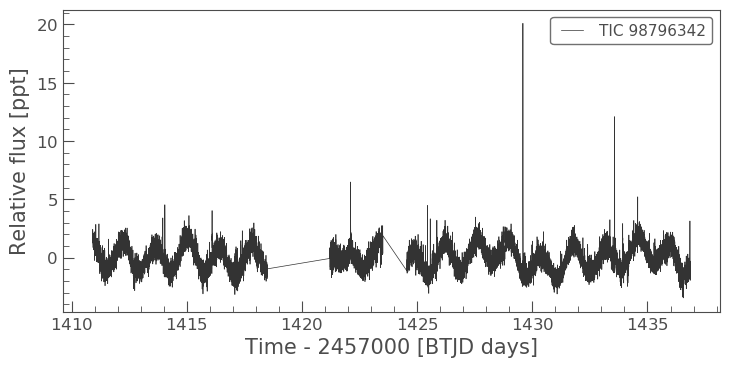

In [3]:
# make a light curve
tpf = lk.TessTargetPixelFile("/home/tom/.lightkurve-cache/mastDownload/TESS/tess2018292075959-s0004-0000000098796342-0124-s/tess2018292075959-s0004-0000000098796342-0124-s_tp.fits")
# tpf = lk.search_targetpixelfile('LTT 1445')
pix_mask = tpf.create_threshold_mask(threshold=2)
corrector = lk.PLDCorrector(tpf)
lc = corrector.correct(aperture_mask=pix_mask, simple_tom=True,
                       cadence_mask=None,
                       use_gp=False)
lc.flux = lc.flux  * 1e3
lc.plot(normalize=False, ylabel='Relative flux [ppt]')


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


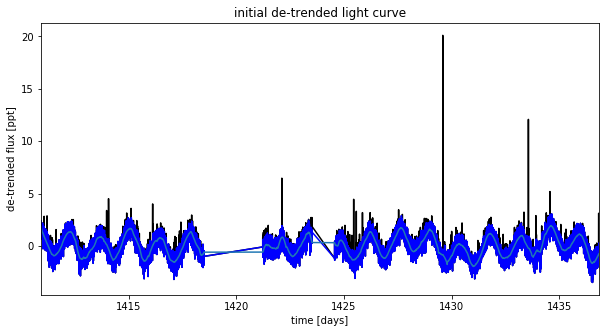

In [4]:
# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 301, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "k")
plt.plot(lc.time[mask], lc.flux[mask], "b")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [5]:
# find some flares
mflare = resid < 2.5 * np.sqrt(np.mean(resid**2))
cads = lc.cadenceno - lc.cadenceno[0]
x = lc.time
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1][np.diff(cads[~mflare]) < 2]
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            i += 1
            n = 1
    except IndexError:
        break
tpeaks = np.array([lc.time[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.array([resid[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
fwhms = np.ones_like(ampls) * 0.01
npeaks = np.shape(tpeaks)[0]
print(npeaks)

16


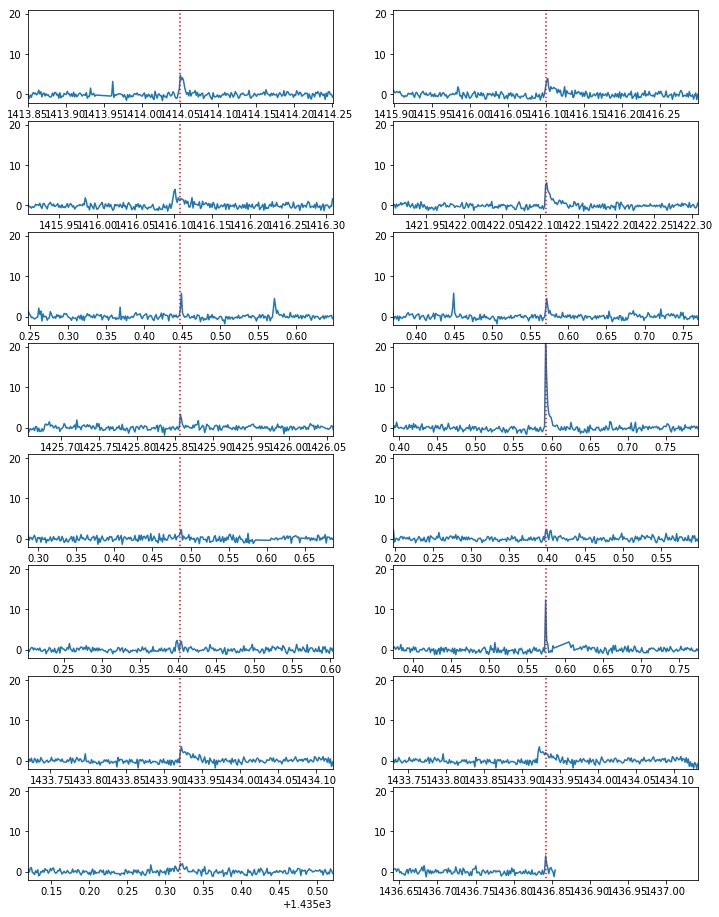

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(y))

In [7]:
def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
npeaks = 10
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    multiflaremodel(xx, tpeaksx, fwhmsx, amplsx))

In [8]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=2.0, testval=np.log(0.005),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    flare_lc = multiflaremodel(x, tpeak, fwhm, ampl)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
    map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
    map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
    map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.2056e+05, ||grad|| = 14.266: 100%|██████████| 49/49 [00:00<00:00, 163.43it/s]  
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.2018e+05, ||grad|| = 31.422: 100%|██████████| 58/58 [00:00<00:00, 165.43it/s]   

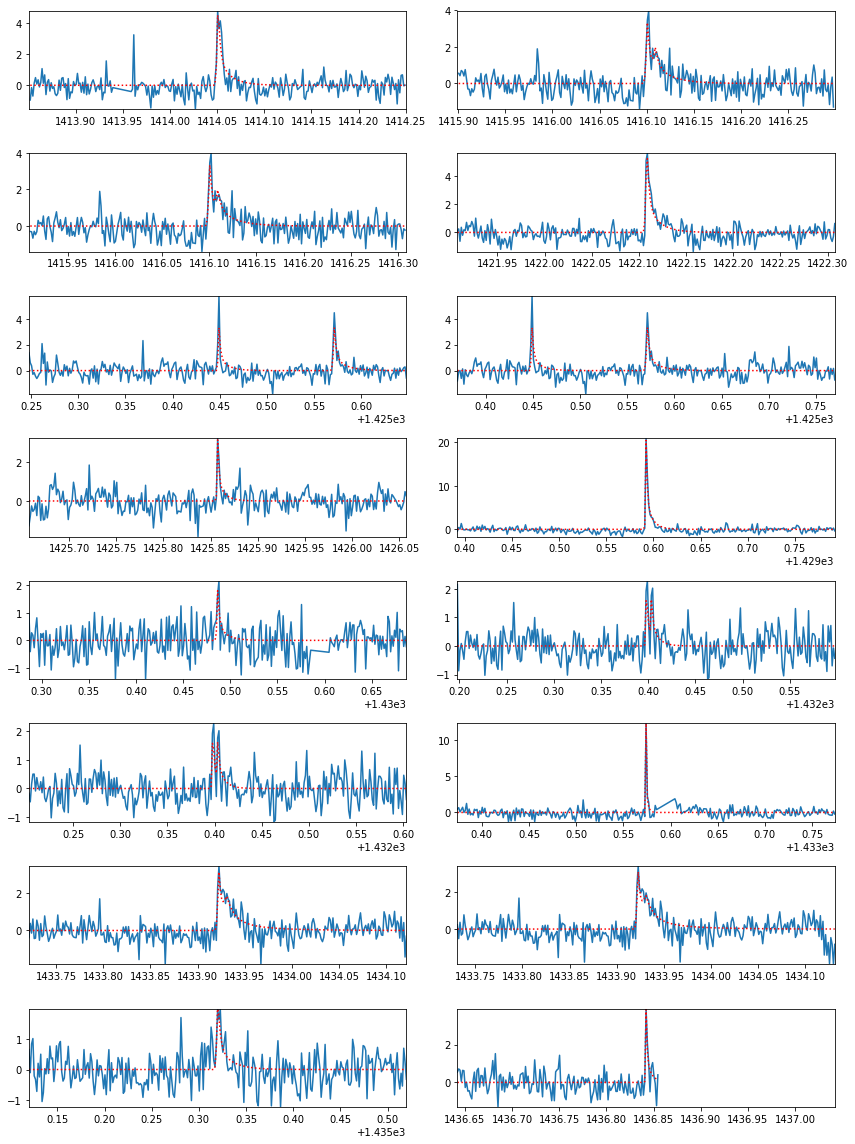

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], map_soln['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

In [10]:
sampler = xo.PyMC3Sampler(window=200, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=3000, step_kwargs=dict(target_accept=0.9))

Sampling 4 chains: 100%|██████████| 808/808 [05:45<00:00,  1.38s/draws]


In [11]:
start, step = sampler._get_start_and_step()
with model:
    step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=3000, tune=200, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
Sampling 4 chains: 100%|██████████| 12800/12800 [5:25:03<00:00,  3.67s/draws]  
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7753525736749518, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance prob

In [12]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logAmpl__0,1.796428,0.102267,4.294529e-03,1.593073,1.994703,389.192171,1.004514
logAmpl__1,-0.133096,0.648751,6.019327e-02,-1.519447,0.900057,4.571050,1.502644
logAmpl__2,1.445678,0.141484,8.347206e-03,1.180505,1.725466,84.358296,1.006133
logAmpl__3,2.096767,0.088556,5.972972e-03,1.929698,2.271510,30.076221,1.072662
logAmpl__4,2.017647,0.384869,2.984222e-02,1.520295,2.707959,30.954836,1.050098
logAmpl__5,1.592874,0.184172,1.400046e-02,1.229656,1.965940,13.499986,1.147221
logAmpl__6,1.056057,0.231536,2.063041e-02,0.609180,1.535825,13.013506,1.139202
logAmpl__7,3.545694,0.105254,1.247096e-03,3.351482,3.761488,5722.082710,1.000454
logAmpl__8,0.227468,0.317852,2.795218e-02,-0.426157,0.870590,6.485430,1.314580
logAmpl__9,-0.122807,1.064230,1.025884e-01,-2.287202,1.557561,7.199181,1.318360


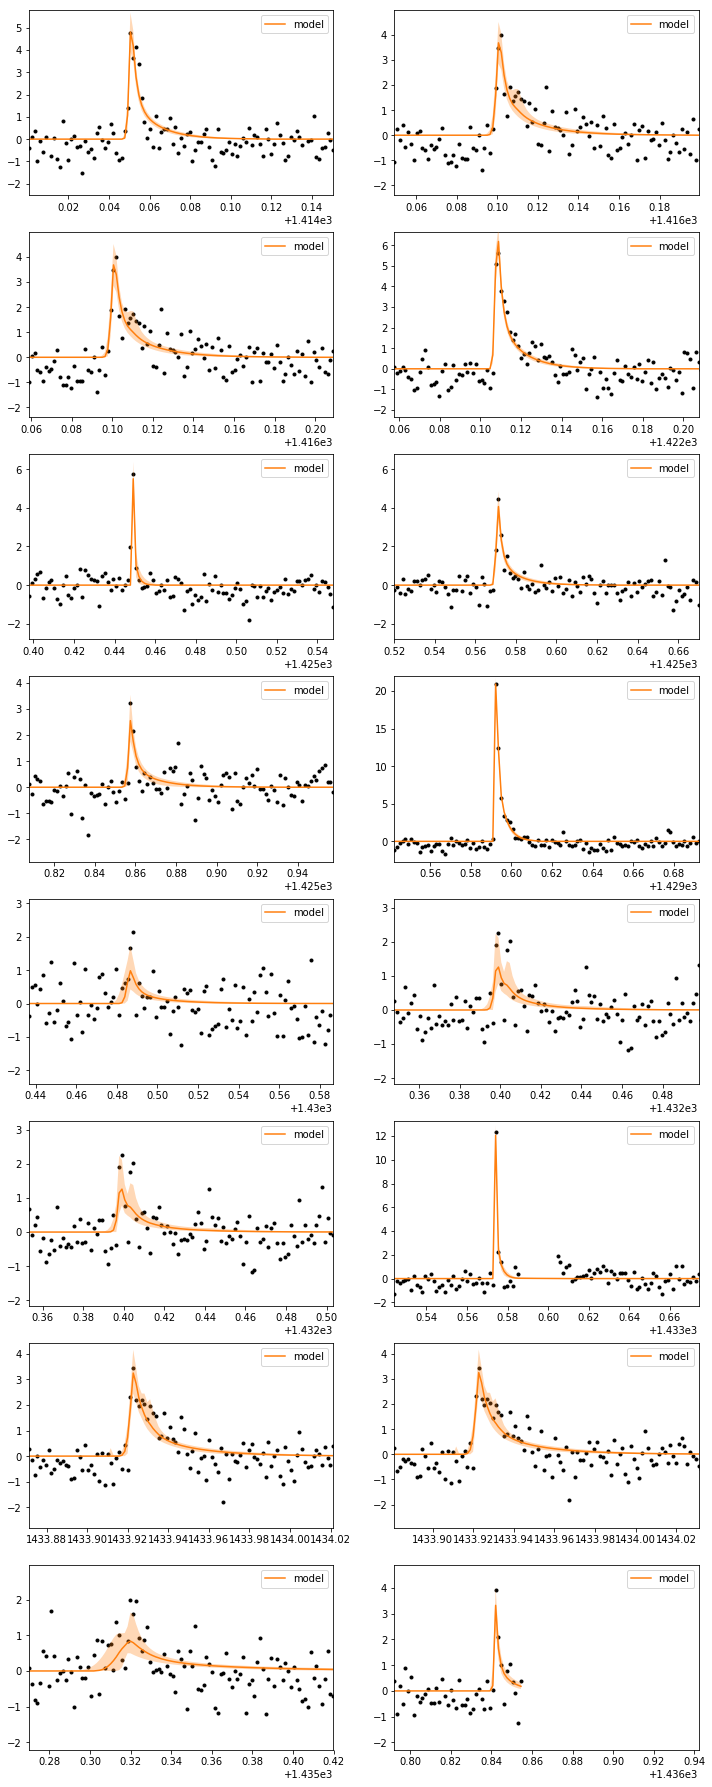

In [16]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()


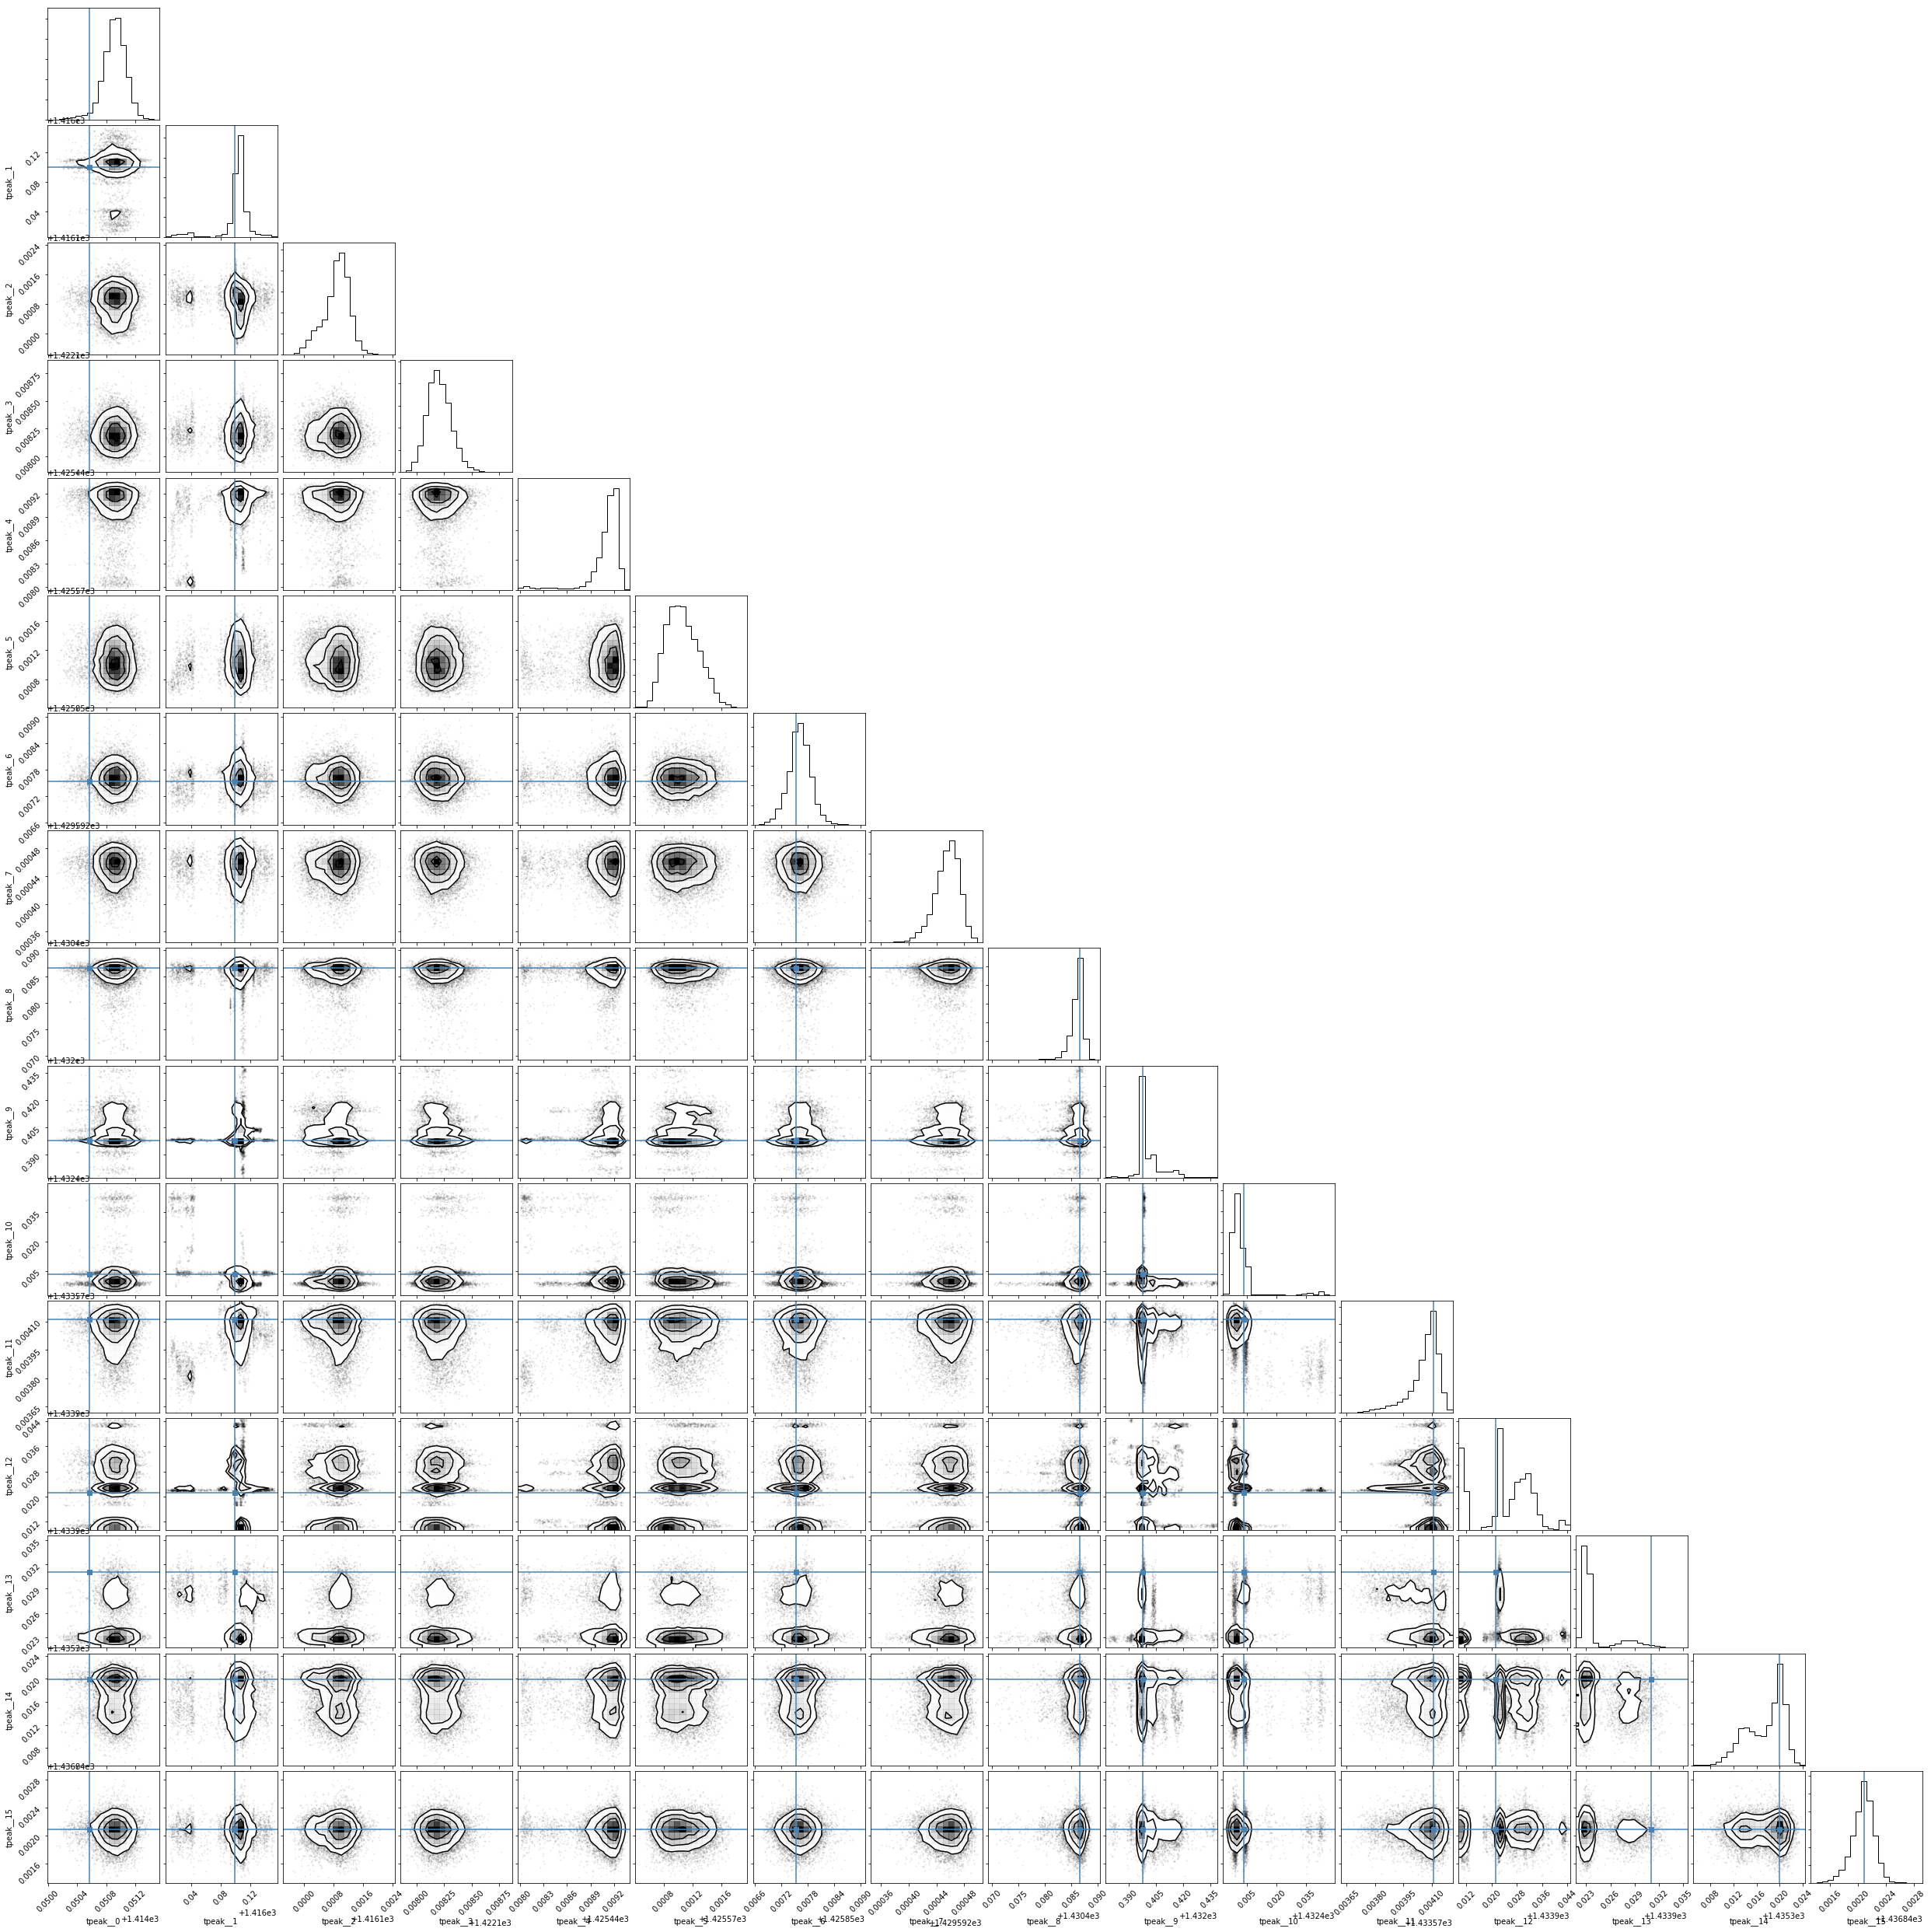

In [15]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=['tpeak'])
corner.corner(samples, truths=tpeaks);